In [49]:

import os
import pandas as pd
import cv2
import numpy as np

# Function to load the dataset
def load_dataset(dataset_folder):
    # Define the paths for CSV and images based on the full dataset path
    csv_path = os.path.join(dataset_folder, 'labels.csv')  # Assuming the CSV is named 'labels.csv'
    image_folder = os.path.join(dataset_folder, 'images')  # Assuming images are in a folder named 'images'
    
    # Check if the CSV exists at the path
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV file not found at {csv_path}")
    
    # Load the CSV containing image paths and labels
    df = pd.read_csv(csv_path)
    
    # Verify if 'image_path' and 'medicine_name' columns exist
    if 'IMAGE' not in df.columns or 'MEDICINE_NAME' not in df.columns:
        raise ValueError("CSV must contain 'image_path' and 'MEDICINE_NAME' columns")
    
    return df, image_folder

# Set the correct dataset path
relative_dataset_path = os.path.join('..', 'dataset')  # '..' means move up one level from 'preprocessing'

# Define paths for each dataset (Training, Validation, Testing)
train_folder = os.path.join(relative_dataset_path, 'Training')
val_folder = os.path.join(relative_dataset_path, 'Validation')
test_folder = os.path.join(relative_dataset_path, 'Testing')

# Load datasets for each folder
training_df, training_image_folder = load_dataset(train_folder)
validation_df, validation_image_folder = load_dataset(val_folder)
testing_df, testing_image_folder = load_dataset(test_folder)

# Print the first few rows of the dataset to verify
print(training_df.head())


   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol


Model Input Shape: (None, 28, 28, 1)


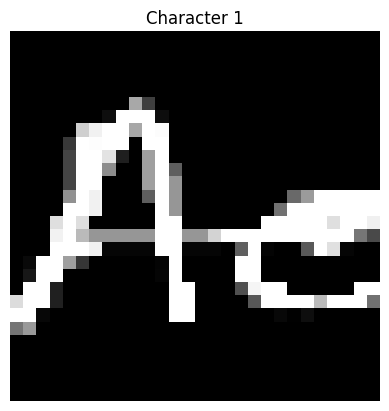

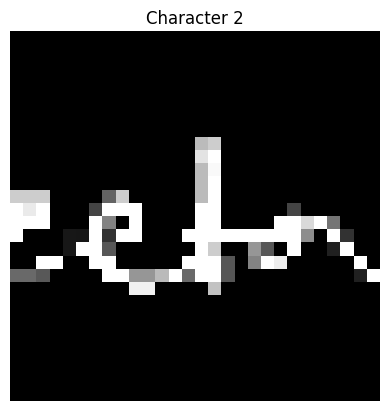

Reconstructed Text: QF


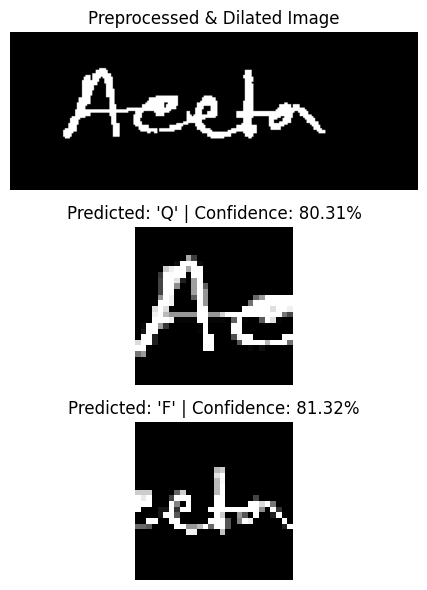

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 1️⃣ Function to preprocess the image (Otsu's Thresholding + Dilation)
def preprocess_image_otsu(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Correct Otsu's Thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Apply dilation to connect broken letters
    kernel = np.ones((2, 2), np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    
    return dilated

# 2️⃣ Function to pad and resize images (maintaining aspect ratio)
def pad_and_resize(image, size=28):
    h, w = image.shape[:2]
    diff = abs(h - w)
    pad1, pad2 = diff // 2, diff - (diff // 2)

    if h > w:
        padded = cv2.copyMakeBorder(image, 0, 0, pad1, pad2, cv2.BORDER_CONSTANT, value=0)
    else:
        padded = cv2.copyMakeBorder(image, pad1, pad2, 0, 0, cv2.BORDER_CONSTANT, value=0)

    # Resize and normalize to [0, 1]
    resized = cv2.resize(padded, (size, size))
    resized = resized.astype('float32') / 255
    return resized

# 3️⃣ Function to segment characters from the preprocessed image
def segment_characters(image):
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours left to right
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    characters = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Filter out small contours
        if w < 10 or h < 10:
            continue

        # Crop and pad the character
        char_img = image[y:y+h, x:x+w]
        char_img_resized = pad_and_resize(char_img)
        characters.append(char_img_resized)
    
    return characters

# 4️⃣ Load the trained CNN model
model = tf.keras.models.load_model('emnist_letter_cnn_tuned.keras')
print("Model Input Shape:", model.input_shape)

# 5️⃣ Function to predict segmented characters
def predict_characters(characters):
    predictions = []
    confidence_scores = []

    for char_img in characters:
        char_img = np.expand_dims(char_img, axis=0)  # Shape: (1, 28, 28)
        char_img = np.expand_dims(char_img, axis=-1) # Shape: (1, 28, 28, 1)

        prediction = model.predict(char_img, verbose=0)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)

        # EMNIST Letters start from 'A' (mapped from 0)
        predicted_char = chr(predicted_class + 65)

        predictions.append(predicted_char)
        confidence_scores.append(confidence)

    return predictions, confidence_scores

# 6️⃣ Example Usage

# Example Image Path
example_image_path = r"D:\jupyter\FYP-OCR\medical_prescription_ocr\dataset\Training\images\0.png"

# Preprocess Image
processed_image = preprocess_image_otsu(example_image_path)

# Segment Characters
characters = segment_characters(processed_image)

# Debug: Visualize Each Segmented Character
for i, char_img in enumerate(characters):
    plt.imshow(char_img, cmap='gray')
    plt.title(f"Character {i+1}")
    plt.axis('off')
    plt.show()

# Predict Using CNN
predicted_labels, confidence_scores = predict_characters(characters)

# Reconstruct Word
reconstructed_text = ''.join(predicted_labels)
print(f"Reconstructed Text: {reconstructed_text}")

# 7️⃣ Visualize Final Results
fig, axes = plt.subplots(len(characters) + 1, 1, figsize=(5, 2 * (len(characters) + 1)))

# Display Preprocessed Image
axes[0].imshow(processed_image, cmap='gray')
axes[0].axis('off')
axes[0].set_title("Preprocessed & Dilated Image")

# Display Each Character with Prediction and Confidence
for i, char_img in enumerate(characters):
    axes[i+1].imshow(char_img, cmap='gray')
    axes[i+1].axis('off')
    axes[i+1].set_title(f"Predicted: '{predicted_labels[i]}' | Confidence: {confidence_scores[i]*100:.2f}%")

plt.tight_layout()
plt.show()
